# Multinomial Naive Bayes Machine Learning Algorithm using SKLearn
Predicting subreddit class from a body of text and title using Multinomial Naive Bayes Machine Learning Algorithm from scikit learn machine learning library

## Import Libraries and Functions
- Import libraries
- Import stopwords
- Import utility functions
- Pandas options and settings

In [9]:
# * Import libraries
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
from datetime import datetime
from pandas import DataFrame
from numpy import int64
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import joblib
import re
import os

cleaning_regex = re.compile(r"[^\w\s]")
current_path = str(pathlib.Path().resolve())

dataset_dir = f'{current_path}\\datasets\\'
model_dir = f'{current_path}\\models\\sklearn\\model\\'
tfidf_dir = f'{current_path}\\models\\sklearn\\tfidf\\'
classification_report_dir = f'{current_path}\\metrics\\classification-report\\sklearn\\'
confusion_matrix_dir = f'{current_path}\\metrics\\confusion-matrix\\sklearn\\'

# * Import stopwords
print(f'Loading English and Tagalog stopwords...')
eng_file_path = f'{str(pathlib.Path().resolve())}\\stopwords\\english_stopwords.txt'
tag_file_path = f'{str(pathlib.Path().resolve())}\\stopwords\\tagalog_stopwords.txt'
eng_stop = set()
tag_stop = set()

with open(eng_file_path, 'r') as f:
    for i, line in enumerate(f):
        eng_stop.add(line.replace('\n', ''))

with open(tag_file_path, 'r') as f:
    for i, line in enumerate(f):
        tag_stop.add(line.replace('\n', ''))

# * Import utility functions
def timestamp_str_to_epoch(time='2024-01-01 00:00:00') -> int:
    """ Converts timestamp in string to epoch integer, GMT +local is applied """
    return int(datetime.strptime(time, '%Y-%m-%d %H:%M:%S').timestamp())

def save_model_and_tfidf(model: MultinomialNB, tfidf: TfidfVectorizer):
    """ Save the model using joblib """
    existing_files_model = [f for f in os.listdir(model_dir)]
    id_model = len(existing_files_model) + 1
    existing_files_tfidf = [f for f in os.listdir(tfidf_dir)]
    id_tfidf = len(existing_files_tfidf) + 1

    joblib.dump(model, f'{model_dir}mnb_model_sklearn{id_model}.pkl')
    joblib.dump(tfidf, f'{tfidf_dir}mnb_tfidf_sklearn{id_tfidf}.pkl')

    print(f'Model saved as mnb_model_sklearn{id_model}.pkl...')
    print(f'TF-IDF saved as mnb_tfidf_sklearn{id_tfidf}.pkl...')

def save_classification_report(report: str | dict):
    """ Save classification report as a text file """
    existing_files = [f for f in os.listdir(classification_report_dir)]
    id = len(existing_files) + 1
    with open(f'{classification_report_dir}\\mnb_report_sklearn{id}.txt', 'w') as f:
        f.write(report)
    print(f'Classification report saved as mnb_report_sklearn{id}.txt...')

def save_confusion_matrix(fig):
    """ Save confusion matrix as a PNG file """
    existing_files = [f for f in os.listdir(confusion_matrix_dir)]
    id = len(existing_files) + 1
    fig.savefig(f'{confusion_matrix_dir}\\mnb_conf_matrix_sklearn{id}.png', dpi=1200, bbox_inches='tight')
    print(f'Confusion matrix saved as mnb_conf_matrix_sklearn{id}.png...')

# * Pandas options and settings
# Set option for printing out the maximum rows and column
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)

# Set option for increasing display width
pd.set_option('display.width', 30)
pd.set_option('display.max_colwidth', 30)

Loading English and Tagalog stopwords...


## Implement Transform and Cleaning Method
- Function implementation for transforming and cleaning the datasets
- Function implementation for transforming and cleaning a time-based datasets

In [3]:
# * Function implementation for transforming and cleaning the datasets

def import_transform_datasets(classes: list[str], dataset_path: str, n_sample: int) -> DataFrame:
    """ Transform and clean the dataset for each class, returns the dataframe """

    d_types ={
        'title': object, 
        'text_content': object, 
        'created_utc': int64, 
        'subreddit_subscribers': int64, 
        'author': object, 
        'author_id': object, 
        'hash_sha256': object, 
        'url_link': object 
    }

    data = []
    # Import the dataframe from a CSV file
    print('Importing the dataset...')
    for c in classes:
        df = pd.read_csv(f'{dataset_path}\\{c}_submissions.csv', index_col='id', dtype=d_types)
        df['subreddit'] = c
        data.append(df)

    df = pd.concat(data)
    # Remove duplicated title and text content for all classes
    df = df.loc[~df.duplicated(subset=['text_content', 'title'], keep=False)]
    data = []

    # Merge title and text content into one block of text
    print('Merging title and text content...')
    df['text_content'] = df['title'].fillna('') + ' ' + df['text_content'].fillna('')
    df = df[['subreddit', 'text_content']]

    # Gather n variable number of sample from each class
    print(f'Gathering {n_sample} sample from the dataset...')
    data_sample = []
    for c in classes:
        data_sample.append(df[df['subreddit'] == c].sample(n=n_sample))
    
    df = pd.concat(data_sample)
    data_sample = []

    # Tokenize the corpus
    print('Tokenizing the corpus...')
    df['tokens'] = df['text_content'].str.lower()
    df['tokens'] = df['tokens'].str.replace(cleaning_regex, ' ', regex=True)
    df['tokens'] = df['tokens'].apply(lambda x: ' '.join([
        token for token in word_tokenize(x)
        if len(token) > 2 and token not in eng_stop and token not in tag_stop]))

    return df

# * Function implementation for transforming and cleaning a time-based datasets
def transform_time_based_dataset(df_train: DataFrame, df_validation: DataFrame) -> tuple[DataFrame, DataFrame]:
    """ Transform and clean a single time-based pre-processed dataset from a class, returns training and validation dataframe"""

    # Merge title and text content into one block of text
    print('Merging title and text content...')
    df_train['text_content'] = df_train['title'].fillna('') + ' ' + df_train['text_content'].fillna('')
    df_train = df_train[['subreddit', 'created_utc', 'text_content']]
    df_validation['text_content'] = df_validation['title'].fillna('') + ' ' + df_validation['text_content'].fillna('')
    df_validation = df_validation[['subreddit', 'created_utc', 'text_content']]

    # Tokenize the corpus
    print('Tokenizing the corpus...')
    df_train_copy = df_train.copy()  # Create a copy to avoid setting on a slice
    df_validation_copy = df_validation.copy()

    df_train_copy.loc[:, 'tokens'] = df_train_copy['text_content'].str.lower()
    df_train_copy.loc[:, 'tokens'] = df_train_copy['tokens'].str.replace(cleaning_regex, ' ', regex=True)
    df_train_copy.loc[:, 'tokens'] = df_train_copy['tokens'].apply(lambda x: ' '.join([
        token for token in word_tokenize(x)
        if len(token) > 2 and token not in eng_stop and token not in tag_stop]))
    
    df_validation_copy.loc[:, 'tokens'] = df_validation_copy['text_content'].str.lower()
    df_validation_copy.loc[:, 'tokens'] = df_validation_copy['tokens'].str.replace(cleaning_regex, ' ', regex=True)
    df_validation_copy.loc[:, 'tokens'] = df_validation_copy['tokens'].apply(lambda x: ' '.join([
        token for token in word_tokenize(x)
        if len(token) > 2 and token not in eng_stop and token not in tag_stop]))

    return (df_train_copy, df_validation_copy)

## Main Execution
After implementing data transformation and cleaning process. Proceed to training the model, and then evaluate the model
- Data Preparation and Pre-processing
    - Random-Based Dataset Splitting
    - Time-Based Dataset Splitting
- Training
    - Random-Based Dataset Splitting
    - Time-Based Dataset Splitting
- Evaluation
    - Evaluate the model
    - Classification report
    - Confusion matrix 

### Data Preparation and Pre-processing

#### Random-Based Dataset Splitting
Splitting dataset to training and validation datasets

In [4]:
# Transform and clean the dataset

dataset_path = f'{dataset_dir}2024\\'

classes = [
    'DeepThoughts', 
    'CryptoCurrencies', 
    'askphilosophy', 
    'computerscience',
    'LawSchool', 
    'Wallstreetbetsnew', 
    'PoliticalDiscussion', 
    'geopolitics'
]

# ! If this causes an error due to small sample size, reduce the number for n_sample
df = import_transform_datasets(classes=classes, dataset_path=dataset_path, n_sample=2000)
df


Importing the dataset...
Merging title and text content...
Gathering 2000 sample from the dataset...
Tokenizing the corpus...


,subreddit,text_content,tokens
id,,,
6826,DeepThoughts,Awareness alone can instan...,awareness alone instantly ...
3492,DeepThoughts,The truth doesn't mind bei...,truth mind faith questione...
2779,DeepThoughts,What would you do if your ...,daughter sentenced death a...
7414,DeepThoughts,The world is flat What the...,world flat post says deep ...
2000,DeepThoughts,Unpopular opinion What’s a...,unpopular opinion unpopula...
...,...,...,...
953,geopolitics,Do you guys think WW3 is l...,guys ww3 likely happen gon...
871,geopolitics,What would the likes of Ja...,likes japan australia new ...
7790,geopolitics,Was the ‘opening up’ of Ch...,opening china 1972 nixon a...


#### Time-Based Dataset Splitting
Dataset splitted in training and validation dataset based on the date of submission

In [23]:
# Import and pre-process the dataframe

dataset_path = f'{dataset_dir}2024\\'

classes = [
    'DeepThoughts', 
    'CryptoCurrencies', 
    'askphilosophy', 
    'computerscience',
    'LawSchool', 
    'Wallstreetbetsnew', 
    'PoliticalDiscussion', 
    'geopolitics'
]

d_types ={
    'title': object, 
    'text_content': object, 
    'created_utc': int64, 
    'subreddit_subscribers': int64, 
    'author': object, 
    'author_id': object, 
    'hash_sha256': object, 
    'url_link': object 
}

data = []
print('Importing the dataset...')
for c in classes:
    df = pd.read_csv(f'{dataset_path}\\{c}_submissions.csv', index_col='id', dtype=d_types)
    df['subreddit'] = c
    data.append(df)

df = pd.concat(data)
data = []

# Remove duplicated title and text content for all classes
df = df.loc[~df.duplicated(subset=['text_content', 'title'], keep=False)]

# Split the dataset into training and validation by date of submission
print('Splitting dataset into training and validation dataset...')
jan2024 = timestamp_str_to_epoch(time='2024-01-01 00:00:00')
june2024 = timestamp_str_to_epoch(time='2024-06-01 00:00:00')

# Dataset between January 2024 and June 2024 is use for training, while dataset beyond June 2024 is for validation
# Condition the dataset
condition_train = (df['created_utc'] > jan2024) & (df['created_utc'] < june2024)
df_train = df[condition_train]
df_valid = df[~condition_train]

df_stats = pd.DataFrame(columns=['subreddit', 'training', 'validation'])
for c in classes:
    # Get the size of training and validation dataset for each class
    new_row = pd.DataFrame({
        'subreddit': [c], 
        'training': [df_train[df_train['subreddit'] == c].shape[0]], 
        'validation': [df_valid[df_valid['subreddit'] == c].shape[0]]
    })
    df_stats = pd.concat([df_stats, new_row], ignore_index=True)

# Get the minimum size of rows for each training and validation dataset to sample a balance number of rows for each class
print(f'\nSizes:\nTraining minimum: {df_stats["training"].min()}\nValidation minimum: {df_stats["validation"].min()}')
df_stats

Importing the dataset...
Splitting dataset into training and validation dataset...

Sizes:
Training minimum: 1649
Validation minimum: 1282


,subreddit,training,validation
0,DeepThoughts,3849,4853
1,CryptoCurrencies,1970,1622
2,askphilosophy,8919,6927
3,computerscience,4908,3065
4,LawSchool,10671,8318
5,Wallstreetbetsnew,1649,1282
6,PoliticalDiscussion,5806,8391
7,geopolitics,4871,3436


In [24]:
# Now that we have an idea of the minimum of rows for each training and validation dataset
# Sample n variable number of rows from each class for use in training and validation
sample_train = []
sample_valid = []
for c in classes:
    # Set sample size less than the minimum
    sample_train.append(df_train[df_train['subreddit'] == c].sample(n=1500))
    sample_valid.append(df_valid[df_valid['subreddit'] == c].sample(n=500))

df_train = pd.concat(sample_train)
df_valid = pd.concat(sample_valid)
sample_train = []
sample_valid = []

# Transform and clean the dataset
for c in classes:
    filt_train = df_train['subreddit'] == c
    filt_valid = df_valid['subreddit'] == c

    df_train_processed, df_valid_processed = transform_time_based_dataset(df_train=df_train[filt_train].copy(), df_validation=df_valid[filt_valid].copy())
    sample_train.append(df_train_processed)
    sample_valid.append(df_valid_processed)

df_train = pd.concat(sample_train)
df_valid = pd.concat(sample_valid)

Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...
Merging title and text content...
Tokenizing the corpus...


In [25]:
# * Inspect the training dataset
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_colwidth', 1000)

df_train[df_train['subreddit'] == 'computerscience'].sort_values(by=['created_utc'])

,subreddit,created_utc,text_content,tokens
id,,,,
5,computerscience,1704088945,Exploring the Intriguing W...,exploring intriguing world...
6,computerscience,1704091093,Need some hacks!,need hacks
7,computerscience,1704092047,It’s so hard to find a pro...,programmer job usa interna...
8,computerscience,1704097491,Which do I take between CS...,254 262
10,computerscience,1704103906,Entry level is insane in 2...,entry level insane 2024
...,...,...,...,...
5227,computerscience,1717136931,Something even more basic ...,something basic crash cour...
5230,computerscience,1717145249,Readers Writers concurrenc...,readers writers concurrenc...
5231,computerscience,1717146539,Books that cover the absol...,books cover absolute basic...


In [26]:
# * Inspect the validation dataset

df_valid[df_valid['subreddit'] == 'computerscience'].sort_values(by=['created_utc'])

,subreddit,created_utc,text_content,tokens
id,,,,
5261,computerscience,1717270724,teaching young kids coding...,teaching young kids coding...
5275,computerscience,1717312880,Roast my Turing Machine (T...,roast turing machine types...
5300,computerscience,1717406657,I'm stuck at first step of...,stuck step dsa barely pass...
5303,computerscience,1717411386,Query about coding,query coding
5304,computerscience,1717414149,Best course/book for learn...,course book learning compu...
...,...,...,...,...
8430,computerscience,1727606682,Conversion algorithm help,conversion algorithm
8436,computerscience,1727616072,How much physical memory c...,physical memory cells bit ...
8441,computerscience,1727634752,Would a meteor from outer ...,meteor outer space impalin...


In [27]:
# * Inspect for any duplication of data from training and validation dataset
# Ensure unique rows for training and validation dataset

df_train_and_valid = pd.concat([df_train, df_valid], ignore_index=True)
df_train_and_valid.loc[df_train_and_valid.duplicated(subset=['text_content', 'tokens'], keep=False)]

,subreddit,created_utc,text_content,tokens


### Training

#### Training using Random-Based Dataset
Only run this cell if you use random-based dataset splitting

In [5]:
X = df['text_content'] # Features
y = df['subreddit'] # Target

# * Split the dataset into training and validation dataset
print('Splitting the dataset into training and validation dataset...')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# * Apply vectorization using TF-IDF
print('Vectorizing using TF-IDF...')
tfidf = TfidfVectorizer(max_features=15_000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# * Train the model
print('Training the model...')
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Save model (optional)
# save_model_and_tfidf(model, tfidf)

Splitting the dataset into training and validation dataset...
Vectorizing using TF-IDF...
Training the model...


MultinomialNB()

#### Training using Time-Based Dataset
Only run this cell if you use time-based dataset splitting

In [28]:
# Define features (X) and target (y) for both training and validation sets
X_train = df_train['text_content'] # Features for training
y_train = df_train['subreddit'] # Target for training

X_val = df_valid['text_content'] # Features for validation
y_val = df_valid['subreddit'] # Target for validation

# Apply vectorization using TF-IDF
print('Vectorizing using TF-IDF...')
tfidf = TfidfVectorizer(max_features=20_000)

# Fit on training data and transform both training and validation sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# Train the model
print('Training the model...')
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

Vectorizing using TF-IDF...
Training the model...


MultinomialNB()

### Evaluation

In [6]:
# Evaluate the model
y_pred = model.predict(X_val_tfidf)
# Classification report
report = classification_report(y_val, y_pred)
# Save report (optional)
# save_classification_report(report)
print(report)

Classification report saved as mnb_report_sklearn2.txt...
                     precision    recall  f1-score   support

   CryptoCurrencies       0.86      0.71      0.78       395
       DeepThoughts       0.65      0.76      0.70       372
          LawSchool       0.76      0.89      0.82       459
PoliticalDiscussion       0.86      0.67      0.75       369
  Wallstreetbetsnew       0.81      0.79      0.80       400
      askphilosophy       0.70      0.83      0.76       416
    computerscience       0.88      0.72      0.79       421
        geopolitics       0.80      0.84      0.82       368

           accuracy                           0.78      3200
          macro avg       0.79      0.78      0.78      3200
       weighted avg       0.79      0.78      0.78      3200



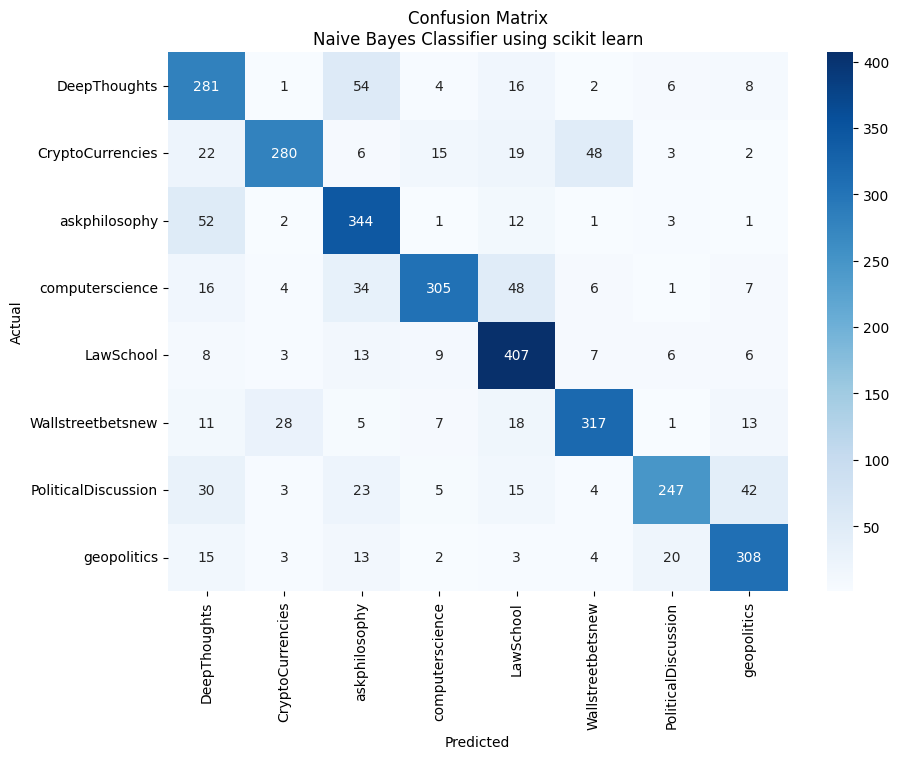

Confusion matrix saved as mnb_conf_matrix_sklearn2.png...


In [7]:
# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred, labels=classes)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix\nNaive Bayes Classifier using scikit learn')
plt.show()
# Save confusion matrix (optional)
# save_confusion_matrix(fig)

### Prediction

In [ ]:
def predict(text):
    # Transform the input text using the same TF-IDF vectorizer used for training
    text_transformed = tfidf.transform([text])
    # Make a prediction
    prediction = model.predict(text_transformed)
    # Return the predicted subreddit
    return prediction[0]

# Paste the body of text and/or title from a submission
text = """

"""

# Clean the text
tokenize = lambda x: ' '.join([token for token in word_tokenize(x) if len(token) > 2 and token not in eng_stop and token not in tag_stop])
tokens = tokenize(re.sub(cleaning_regex, ' ', text.lower()))

predict(tokens)